# Molecular Oncology Almanac Assertion Analysis

MOA evidence items are referred to as assertions and MOA variants are referred to as features in this analysis. 

In [3]:
from enum import Enum
from typing import Dict
import json

import pandas as pd
import plotly.express as px
import requests
from ga4gh.core import sha512t24u


In [4]:
def get_feature_digest(feature: Dict) -> str:
    """Get digest for feature

    :param feature: MOA feature
    :return: Digest
    """
    attrs = json.dumps(
        feature["attributes"][0],
        sort_keys=True,
        separators=(",", ":"),
        indent=None
    ).encode("utf-8")
    return sha512t24u(attrs)

In [5]:
class VariantNormType(str, Enum):
    """Variation Normalization types"""

    NORMALIZED = "Normalized"
    NOT_SUPPORTED = "Not Supported"


VARIANT_NORM_TYPE_VALUES = [v.value for v in VariantNormType.__members__.values()]

In [6]:
class VariantCategory(str, Enum):
    """Create enum for the kind of variants that are in MOA."""

    EXPRESSION = "Expression"
    EPIGENETIC_MODIFICATION = "Epigenetic Modification"
    FUSION = "Fusion"
    PROTEIN_CONS = "Protein Consequence"
    GENE_FUNC = "Gene Function"
    REARRANGEMENTS = "Rearrangements"
    COPY_NUMBER = "Copy Number"
    OTHER = "Other"
    GENOTYPES_EASY = "Genotypes Easy"
    GENOTYPES_COMPOUND = "Genotypes Compound"
    REGION_DEFINED_VAR = "Region Defined Variant"
    TRANSCRIPT_VAR = "Transcript Variant"  # no attempt to normalize these ones, since there is no query we could use


VARIANT_CATEGORY_VALUES = [v.value for v in VariantCategory.__members__.values()]

## All Features (Variants) Analysis

### Creating a table with feature (variant) and assertion (evidence) information

In [7]:
# Create dictionary for MOA Feature ID -> Feature Type
r = requests.get("https://moalmanac.org/api/features")
if r.status_code == 200:
    feature_data = r.json()

features = {}

for feature in feature_data:
    feature_id = feature["feature_id"]
    digest = get_feature_digest(feature)
    features[digest] = feature["feature_type"]

len(features.keys())


423

In [8]:
# Create DF for assertions and their associated feature + predictive implication
r = requests.get("https://moalmanac.org/api/assertions")
if r.status_code == 200:
    assertion_data = r.json()

transformed = []

# Mapping from feature ID to feature digest
feature_id_to_digest = {}

for assertion in assertion_data:
    assertion_id = assertion["assertion_id"]
    predictive_implication = assertion["predictive_implication"]

    if len(assertion["features"]) != 1:
        print(f"assertion id ({assertion_id}) does not have 1 feature")
        continue

    feature = assertion["features"][0]
    feature_id = feature["feature_id"]
    feature_digest = get_feature_digest(feature)

    feature_id_to_digest[feature_id] = digest

    transformed.append(
        {
            "assertion_id": assertion_id,
            "feature_id": feature_id,
            "feature_type": features[feature_digest],
            "predictive_implication": predictive_implication,
            "feature_digest": feature_digest
        }
    )
moa_df = pd.DataFrame(transformed)
moa_df

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
...,...,...,...,...,...
869,870,870,somatic_variant,FDA-Approved,1JInmjKzPW9V9q9UKen4VODk1drBadA2
870,871,871,somatic_variant,FDA-Approved,txWE0iDd8r36tzSRZw9tyMcMz9-L5M0g
871,872,872,copy_number,FDA-Approved,PWxJ97XlgUgdA5hvLmyZENRIL9pTYY84
872,873,873,somatic_variant,FDA-Approved,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E


In [9]:
unique_features_df = moa_df.sort_values("feature_id").drop_duplicates("feature_digest")
len_unique_feature_ids = len(list(unique_features_df.feature_id))

In [10]:
total_len_features = len(moa_df.feature_digest.unique())
f"Total number of unique features (variants): {total_len_features}"

'Total number of unique features (variants): 423'

In [11]:
assert total_len_features == len_unique_feature_ids

In [12]:
total_len_assertions = len(moa_df.assertion_id.unique())
f"Total number of unique assertions (evidence items): {total_len_assertions}"

'Total number of unique assertions (evidence items): 874'

### Converting feature (variant) types to normalized categories

In [13]:
list(moa_df.feature_type.unique())

['rearrangement',
 'somatic_variant',
 'germline_variant',
 'copy_number',
 'microsatellite_stability',
 'mutational_signature',
 'mutational_burden',
 'knockdown',
 'aneuploidy']

In [14]:
moa_df["category"] = moa_df["feature_type"].copy()

moa_df["category"] = moa_df["category"].replace("rearrangement", VariantCategory.REARRANGEMENTS.value)
moa_df["category"] = moa_df["category"].replace("aneuploidy", VariantCategory.COPY_NUMBER.value)
moa_df["category"] = moa_df["category"].replace("knockdown", VariantCategory.EXPRESSION.value)
moa_df["category"] = moa_df["category"].replace("somatic_variant", VariantCategory.PROTEIN_CONS.value)
moa_df["category"] = moa_df["category"].replace("germline_variant", VariantCategory.PROTEIN_CONS.value)
moa_df["category"] = moa_df["category"].replace("microsatellite_stability", VariantCategory.REARRANGEMENTS.value)
moa_df["category"] = moa_df["category"].replace("mutational_burden", VariantCategory.OTHER.value)
moa_df["category"] = moa_df["category"].replace("mutational_signature", VariantCategory.OTHER.value)
moa_df["category"] = moa_df["category"].replace("copy_number", VariantCategory.COPY_NUMBER.value)

moa_df.head()

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements


In [15]:
list(moa_df.category.unique())

['Rearrangements', 'Protein Consequence', 'Copy Number', 'Other', 'Expression']

### Adding a numerical impact score based on the predictive implication
This is based on the structure of MOA scoring

In [16]:
predictive_implication_categories = moa_df.predictive_implication.unique()
list(predictive_implication_categories)

['FDA-Approved',
 'Guideline',
 'Clinical trial',
 'Preclinical',
 'Inferential',
 'Clinical evidence']

In [17]:
moa_df["impact_score"] = moa_df["predictive_implication"].copy()

moa_df.loc[moa_df["impact_score"] == "FDA-Approved", "impact_score"] = 10
moa_df.loc[moa_df["impact_score"] == "Guideline", "impact_score"] = 10
moa_df.loc[moa_df["impact_score"] == "Clinical evidence", "impact_score"] = 5
moa_df.loc[moa_df["impact_score"] == "Clinical trial", "impact_score"] = 5
moa_df.loc[moa_df["impact_score"] == "Preclinical", "impact_score"] = 1
moa_df.loc[moa_df["impact_score"] == "Inferential", "impact_score"] = 1

moa_df.head()

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10


### Impact Score Analysis

In [18]:
feature_categories_impact_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    feature_categories_impact_data[category] = {}
    impact_category_df = moa_df[moa_df.category == category]

    total_sum_category_impact = impact_category_df["impact_score"].sum()
    feature_categories_impact_data[category]["total_sum_category_impact"] = total_sum_category_impact
    print(f"{category}: {total_sum_category_impact}")

Expression: 12
Epigenetic Modification: 0
Fusion: 0
Protein Consequence: 3999
Gene Function: 0
Rearrangements: 644
Copy Number: 415
Other: 62
Genotypes Easy: 0
Genotypes Compound: 0
Region Defined Variant: 0
Transcript Variant: 0


### Features (Variants) Analysis

In [19]:
moa_feature_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    moa_feature_data[category] = {}
    feature_type_df = moa_df[moa_df.category == category]

    number_unique_category_features = len(set(feature_type_df.feature_digest))
    moa_feature_data[category]["number_unique_category_features"] = number_unique_category_features

    fraction_category_feature = f"{number_unique_category_features} / {total_len_features}"
    moa_feature_data[category]["fraction_category_feature"] = fraction_category_feature

    percent_category_feature = "{:.2f}".format(number_unique_category_features / total_len_features * 100) + "%"
    moa_feature_data[category]["percent_category_feature"] = percent_category_feature

### Assertions (Evidence Items) Analysis

In [20]:
moa_assertion_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    moa_assertion_data[category] = {}
    assertion_type_df = moa_df[moa_df.category == category]

    number_unique_category_assertions = len(set(assertion_type_df.assertion_id))
    moa_assertion_data[category]["number_unique_category_assertions"] = number_unique_category_assertions

    fraction_category_assertion = f"{number_unique_category_assertions} / {total_len_assertions}"
    moa_assertion_data[category]["fraction_category_assertion"] = fraction_category_assertion

    percent_category_assertion = "{:.2f}".format(number_unique_category_assertions / total_len_assertions * 100) + "%"
    moa_assertion_data[category]["percent_category_assertion"] = percent_category_assertion

### Summaries for all Features (Variants) and Assertions (Evidence Items)

In [21]:
feature_category_impact_score = [v["total_sum_category_impact"] for v in feature_categories_impact_data.values()]
feature_category_number = [v["number_unique_category_features"] for v in moa_feature_data.values()]
feature_category_fraction = [v["fraction_category_feature"] for v in moa_feature_data.values()]
feature_category_percent = [v["percent_category_feature"] for v in moa_feature_data.values()]
feature_category_assertion_number = [v["number_unique_category_assertions"] for v in moa_assertion_data.values()]
feature_category_assertion_fraction = [v["fraction_category_assertion"] for v in moa_assertion_data.values()]
feature_category_assertion_percent = [v["percent_category_assertion"] for v in moa_assertion_data.values()]

In [22]:
feature_category_dict = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Number of Features": feature_category_number,
    "Fraction of Features": feature_category_fraction,
    "Percent of Features": feature_category_percent,
    "Number of Assertions": feature_category_assertion_number,
    "Fraction of Assertions": feature_category_assertion_fraction,
    "Percent of Assertions": feature_category_assertion_percent,
    "Impact Score": feature_category_impact_score
}

In [23]:
moa_feature_df = pd.DataFrame(feature_category_dict)
moa_feature_df

,Category,Number of Features,Fraction of Features,Percent of Features,Number of Assertions,Fraction of Assertions,Percent of Assertions,Impact Score
0,Expression,11,11 / 423,2.60%,12,12 / 874,1.37%,12
1,Epigenetic Modification,0,0 / 423,0.00%,0,0 / 874,0.00%,0
2,Fusion,0,0 / 423,0.00%,0,0 / 874,0.00%,0
3,Protein Consequence,318,318 / 423,75.18%,656,656 / 874,75.06%,3999
4,Gene Function,0,0 / 423,0.00%,0,0 / 874,0.00%,0
5,Rearrangements,38,38 / 423,8.98%,81,81 / 874,9.27%,644
6,Copy Number,47,47 / 423,11.11%,102,102 / 874,11.67%,415
7,Other,9,9 / 423,2.13%,23,23 / 874,2.63%,62
8,Genotypes Easy,0,0 / 423,0.00%,0,0 / 874,0.00%,0
9,Genotypes Compound,0,0 / 423,0.00%,0,0 / 874,0.00%,0


In [24]:
moa_feature_df["Percent of Features"] = moa_feature_df["Fraction of Features"].astype(str) + " (" + moa_feature_df["Percent of Features"] + ")"
moa_feature_df["Percent of Assertions"] = moa_feature_df["Fraction of Assertions"].astype(str) + " (" + moa_feature_df["Percent of Assertions"] + ")"

In [25]:
moa_feature_df_abbreviated = moa_feature_df.drop(["Number of Features", "Fraction of Features", "Number of Assertions", "Fraction of Assertions"], axis=1)

In [26]:
moa_feature_df_abbreviated = moa_feature_df_abbreviated.set_index("Category")
moa_feature_df_abbreviated

,Percent of Features,Percent of Assertions,Impact Score
Category,,,
Expression,11 / 423 (2.60%),12 / 874 (1.37%),12
Epigenetic Modification,0 / 423 (0.00%),0 / 874 (0.00%),0
Fusion,0 / 423 (0.00%),0 / 874 (0.00%),0
Protein Consequence,318 / 423 (75.18%),656 / 874 (75.06%),3999
Gene Function,0 / 423 (0.00%),0 / 874 (0.00%),0
Rearrangements,38 / 423 (8.98%),81 / 874 (9.27%),644
Copy Number,47 / 423 (11.11%),102 / 874 (11.67%),415
Other,9 / 423 (2.13%),23 / 874 (2.63%),62
Genotypes Easy,0 / 423 (0.00%),0 / 874 (0.00%),0


In [27]:
fig = px.scatter(
    data_frame=moa_feature_df,
    x="Number of Assertions",
    y="Impact Score",
    size="Number of Features",
    size_max=40,
    text="Number of Features",
    color="Category"
)
fig.show()

In [28]:
fig.write_html("moa_feature_categories_impact_scatterplot.html")

## Create functions / global variables used in analysis

In [29]:
feature_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Fraction of all MOA Features": [],
    "Percentage of all MOA Features": []
}
feature_analysis_summary

{'Variant Category': ['Normalized', 'Not Supported'],
 'Fraction of all MOA Features': [],
 'Percentage of all MOA Features': []}

In [30]:
def feature_analysis(df: pd.DataFrame, variant_norm_type: VariantNormType) -> pd.DataFrame:
    """Do feature analysis (counts, percentages). Updates `feature_analysis_summary`

    :param df: Dataframe of variants
    :param variant_norm_type: The kind of features that are in `df`
    :return: Transformed dataframe with variant ID duplicates dropped
    """
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["feature_id"])
    feature_ids = list(df["feature_id"])

    # Count
    num_features = len(feature_ids)
    fraction_features = f"{num_features} / {total_len_features}"
    print(f"\nNumber of {variant_norm_type.value} Features in MOA: {fraction_features}")

    # Percentage
    percentage_features = f"{num_features / total_len_features * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Features in MOA: {percentage_features}")


    feature_analysis_summary["Fraction of all MOA Features"].append(fraction_features)
    feature_analysis_summary["Percentage of all MOA Features"].append(percentage_features)

    return df

In [31]:
assertion_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Fraction of all MOA Assertions": [],
    "Percentage of all MOA Assertions": []
}
assertion_analysis_summary

{'Variant Category': ['Normalized', 'Not Supported'],
 'Fraction of all MOA Assertions': [],
 'Percentage of all MOA Assertions': []}

In [32]:
def assertion_analysis(all_df: pd.DataFrame, variant_norm_df: pd.DataFrame, variant_norm_type: VariantNormType):
    """Do evidence analysis (counts, percentages). Updates `assertion_analysis_summary`

    :param all_df: Dataframe for all assertions and features
    :param variant_norm_df: Dataframe for features given certain `variant_norm_type`
    :param variant_norm_type: The kind of variants that are in `df`
    """
    # Need to do this bc of duplicate features
    _feature_ids = set(variant_norm_df.feature_digest)
    tmp_df = all_df[all_df["feature_digest"].isin(_feature_ids)]
    
    # Count
    num_assertions = len(tmp_df.assertion_id)
    fraction_assertions = f"{num_assertions} / {total_len_assertions}"
    print(f"Number of {variant_norm_type.value} Feature Assertions in MOA: {fraction_assertions}")

    # Percentage
    percentage_assertions = f"{num_assertions / total_len_assertions * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Feature Assertions in MOA: {percentage_assertions}")

    assertion_analysis_summary["Fraction of all MOA Assertions"].append(fraction_assertions)
    assertion_analysis_summary["Percentage of all MOA Assertions"].append(percentage_assertions)

In [33]:
feature_id_to_digest_df = pd.DataFrame(feature_id_to_digest.items(), columns=["feature_id", "feature_digest"])
feature_id_to_digest_df

,feature_id,feature_digest
0,1,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
1,2,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
2,3,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
3,4,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
4,5,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
...,...,...
869,870,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
870,871,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
871,872,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E
872,873,qXCY7CGzeFBIDXYsc18tEVBImkWB_43E


## Normalized Analysis

In [34]:
normalized_queries_df = pd.read_csv("able_to_normalize_queries.csv", sep="\t")
normalized_queries_df = pd.merge(normalized_queries_df, feature_id_to_digest_df, left_on="variant_id", right_on="feature_id")
normalized_queries_df.shape

(179, 7)

In [35]:
normalized_queries_df = pd.merge(normalized_queries_df["variant_id"], moa_df, left_on="variant_id", right_on="feature_id", how="left")
normalized_queries_df = normalized_queries_df.drop(columns=["variant_id"])

In [36]:
normalized_queries_df = feature_analysis(normalized_queries_df, VariantNormType.NORMALIZED)
normalized_queries_df



Number of Normalized Features in MOA: 179 / 423
Percentage of Normalized Features in MOA: 42.32%


,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,71,71,somatic_variant,Preclinical,KgolzM3HWhww4t4HywFYCySUtGRIQ_mx,Protein Consequence,1
1,73,73,somatic_variant,Clinical evidence,j3HtSnIdrU8CcuW8_Qs3qVxOn-kMJV1T,Protein Consequence,5
2,75,75,somatic_variant,Clinical evidence,X_Az48pPjt4IODuY2a50Yl2_1tGopcuF,Protein Consequence,5
3,76,76,somatic_variant,Clinical evidence,LQQXFXpA4FCOQ3Fz4988x2vynER4J-Wh,Protein Consequence,5
4,77,77,somatic_variant,Clinical evidence,DKoCqZUY0WBdUnoly9DL_PAjBBZTs51d,Protein Consequence,5
...,...,...,...,...,...,...,...
174,858,858,copy_number,Clinical evidence,UYE-1dofAcf0kc44xdOY2hxwkMNUzjl7,Copy Number,5
175,859,859,copy_number,Inferential,s8SpNzXJuTJlGEqC0Rk-zd8ke9l4fq00,Copy Number,1
176,868,868,somatic_variant,FDA-Approved,xEngbInsi1BKQp2pVFi44N8CYLj6ZEkD,Protein Consequence,10
177,869,869,somatic_variant,FDA-Approved,fqvuveTjuO96HizOsbWgFQmfF76lGtdl,Protein Consequence,10


In [37]:
assertion_analysis(moa_df, normalized_queries_df, VariantNormType.NORMALIZED)

Number of Normalized Feature Assertions in MOA: 325 / 874
Percentage of Normalized Feature Assertions in MOA: 37.19%


## Not Supported Analysis

In [38]:
not_supported_queries_df = pd.read_csv("not_supported_variants.csv", sep="\t")
not_supported_queries_df = pd.merge(not_supported_queries_df, feature_id_to_digest_df, left_on="variant_id", right_on="feature_id")
not_supported_queries_df.shape

(244, 6)

In [39]:
not_supported_queries_df = pd.merge(not_supported_queries_df["variant_id"], moa_df, left_on="variant_id", right_on="feature_id", how="left")
not_supported_queries_df = not_supported_queries_df.drop(columns=["variant_id"])
not_supported_queries_df

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
1,12,12,rearrangement,FDA-Approved,g99yF3kKnB-We_fMS5RaVygoSuT7qA-I,Rearrangements,10
2,15,15,rearrangement,FDA-Approved,e8PMq2A96-aBJ3Ip74ovx5VOUCztBTq7,Rearrangements,10
3,18,18,rearrangement,Guideline,DxfRiRV-3J6zRON4pnzNJjXkJf2bsp20,Rearrangements,10
4,21,21,rearrangement,Preclinical,BRsPjsZSCyDXnKtBt9XgsWX2JDNWY3FP,Rearrangements,1
...,...,...,...,...,...,...,...
239,849,849,copy_number,Inferential,jLD_tOKaW8wX5P2RiZ7EkMT8yBzfA_U_,Copy Number,1
240,853,853,copy_number,Inferential,3ZPmhQucEgPWkaRLg9viECM4O4pEg-BU,Copy Number,1
241,862,862,copy_number,Preclinical,LwEU_0YQA4iVchOdEiBrq_RmIciU-9EW,Copy Number,1
242,863,863,rearrangement,FDA-Approved,MpJsmn4LCLMXDsTNTTlyV5t3fKAnsJzL,Rearrangements,10


### Feature (Variant) Analysis

In [40]:
not_supported_queries_df = feature_analysis(not_supported_queries_df, VariantNormType.NOT_SUPPORTED)


Number of Not Supported Features in MOA: 244 / 423
Percentage of Not Supported Features in MOA: 57.68%


### Not Supported Feature (Variant) Analysis by Subcategory

In [41]:
not_supported_feature_analysis_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Fraction of all MOA Features": [],
    "Percent of all MOA Features": [],
    "Fraction of Not Supported Features": [],
    "Percent of Not Supported Features": [],
}

In [42]:
not_supported_feature_categories_summary_data = dict()
total_number_unique_not_supported_features = len(set(not_supported_queries_df.feature_id))

for category in VARIANT_CATEGORY_VALUES:  # These are not supported categories
    not_supported_feature_categories_summary_data[category] = {}
    category_df = not_supported_queries_df[not_supported_queries_df.category == category]

    # Count
    number_unique_not_supported_category_features = len(set(category_df.feature_id))
    not_supported_feature_categories_summary_data[category]["number_unique_not_supported_category_features"] = number_unique_not_supported_category_features

    # Fraction
    fraction_not_supported_category_feature_of_moa = f"{number_unique_not_supported_category_features} / {total_len_features}"
    not_supported_feature_categories_summary_data[category]["fraction_not_supported_category_feature_of_moa"] = fraction_not_supported_category_feature_of_moa

    # Percent
    percent_not_supported_category_feature_of_moa = f"{number_unique_not_supported_category_features / total_len_features * 100:.2f}%"
    not_supported_feature_categories_summary_data[category]["percent_not_supported_category_feature_of_moa"] = percent_not_supported_category_feature_of_moa

    # Not supported fraction
    fraction_not_supported_category_feature_of_total_not_supported = f"{number_unique_not_supported_category_features} / {total_number_unique_not_supported_features}"
    not_supported_feature_categories_summary_data[category]["fraction_not_supported_category_feature_of_total_not_supported"] = fraction_not_supported_category_feature_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_feature_of_total_not_supported = f"{number_unique_not_supported_category_features / total_number_unique_not_supported_features * 100:.2f}%"
    not_supported_feature_categories_summary_data[category]["percent_not_supported_category_feature_of_total_not_supported"] = percent_not_supported_category_feature_of_total_not_supported

    not_supported_feature_analysis_summary["Fraction of all MOA Features"].append(fraction_not_supported_category_feature_of_moa)
    not_supported_feature_analysis_summary["Percent of all MOA Features"].append(percent_not_supported_category_feature_of_moa)
    not_supported_feature_analysis_summary["Fraction of Not Supported Features"].append(fraction_not_supported_category_feature_of_total_not_supported)
    not_supported_feature_analysis_summary["Percent of Not Supported Features"].append(percent_not_supported_category_feature_of_total_not_supported)

In [43]:
not_supported_variant_df = pd.DataFrame(not_supported_feature_analysis_summary)
not_supported_variant_df

,Category,Fraction of all MOA Features,Percent of all MOA Features,Fraction of Not Supported Features,Percent of Not Supported Features
0,Expression,11 / 423,2.60%,11 / 244,4.51%
1,Epigenetic Modification,0 / 423,0.00%,0 / 244,0.00%
2,Fusion,0 / 423,0.00%,0 / 244,0.00%
3,Protein Consequence,169 / 423,39.95%,169 / 244,69.26%
4,Gene Function,0 / 423,0.00%,0 / 244,0.00%
5,Rearrangements,38 / 423,8.98%,38 / 244,15.57%
6,Copy Number,17 / 423,4.02%,17 / 244,6.97%
7,Other,9 / 423,2.13%,9 / 244,3.69%
8,Genotypes Easy,0 / 423,0.00%,0 / 244,0.00%
9,Genotypes Compound,0 / 423,0.00%,0 / 244,0.00%


### Not Support Feature (Variant) Assertion (Evidence) Analysis by Subcategory

List all the possible variant categories

In [44]:
not_supported_feature_categories = not_supported_queries_df.category.unique()
[v for v in not_supported_feature_categories]

['Rearrangements', 'Protein Consequence', 'Copy Number', 'Other', 'Expression']

In [45]:
assertion_analysis(moa_df, not_supported_queries_df, VariantNormType.NOT_SUPPORTED)


Number of Not Supported Feature Assertions in MOA: 549 / 874
Percentage of Not Supported Feature Assertions in MOA: 62.81%


In [46]:
not_supported_feature_assertion_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Fraction of MOA Assertions": [],
    "Percent of MOA Assertions": [],
    "Fraction of Not Supported Feature Assertions": [],
    "Percent of Not Supported Feature Assertions": []
}

In [47]:
not_supported_feature_ids = set(not_supported_queries_df.feature_digest)

In [48]:
not_supported_feature_categories_assertion_summary_data = dict()
total_number_not_supported_feature_unique_assertions = len(set(not_supported_queries_df.assertion_id))
not_supported_feature_ids = set(not_supported_queries_df.feature_digest)

for category in VARIANT_CATEGORY_VALUES:    
    not_supported_feature_categories_assertion_summary_data[category] = {}

    # Need to do this bc of duplicate features
    tmp_df = moa_df[moa_df["feature_digest"].isin(not_supported_feature_ids)]
    
    evidence_category_df = tmp_df[tmp_df.category == category]
    
    evidence_category_df = evidence_category_df.drop_duplicates(subset=["assertion_id"])

    # Count
    number_unique_not_supported_category_assertion = len(set(evidence_category_df.assertion_id))
    not_supported_feature_categories_assertion_summary_data[category]["number_unique_not_supported_category_assertion"] = number_unique_not_supported_category_assertion

    # Fraction
    fraction_not_supported_category_feature_assertion_of_moa = f"{number_unique_not_supported_category_assertion} / {total_len_assertions}"
    not_supported_feature_categories_assertion_summary_data[category]["fraction_not_supported_category_feature_assertion_of_moa"] = fraction_not_supported_category_feature_assertion_of_moa

    # Percent
    percent_not_supported_category_feature_assertion_of_moa = f"{number_unique_not_supported_category_assertion / total_len_assertions * 100:.2f}%"
    not_supported_feature_categories_assertion_summary_data[category]["percent_not_supported_category_feature_assertion_of_moa"] = percent_not_supported_category_feature_assertion_of_moa

    # Not supported fraction
    fraction_not_supported_category_feature_assertion_of_total_not_supported = f"{number_unique_not_supported_category_assertion} / {total_number_not_supported_feature_unique_assertions}"
    not_supported_feature_categories_assertion_summary_data[category]["fraction_not_supported_category_feature_assertion_of_total_not_supported"] = fraction_not_supported_category_feature_assertion_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_feature_assertion_of_total_not_supported = f"{number_unique_not_supported_category_assertion / total_number_not_supported_feature_unique_assertions * 100:.2f}%"
    not_supported_feature_categories_assertion_summary_data[category]["percent_not_supported_category_feature_assertion_of_total_not_supported"] = percent_not_supported_category_feature_assertion_of_total_not_supported

    not_supported_feature_assertion_summary["Fraction of MOA Assertions"].append(fraction_not_supported_category_feature_assertion_of_moa)
    not_supported_feature_assertion_summary["Percent of MOA Assertions"].append(percent_not_supported_category_feature_assertion_of_moa)
    not_supported_feature_assertion_summary["Fraction of Not Supported Feature Assertions"].append(fraction_not_supported_category_feature_assertion_of_total_not_supported)
    not_supported_feature_assertion_summary["Percent of Not Supported Feature Assertions"].append(percent_not_supported_category_feature_assertion_of_total_not_supported)


## Impact by Subcategory

In [49]:
not_supported_impact_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "MOA Total Sum Impact Score": [],
    "Total Number Assertions": [v["number_unique_not_supported_category_assertion"] for v in not_supported_feature_categories_assertion_summary_data.values()],
    "Total Number Features": [v["number_unique_not_supported_category_features"] for v in not_supported_feature_categories_summary_data.values()]
}

In [50]:
not_supported_feature_categories_impact_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    not_supported_feature_categories_impact_data[category] = {}
    impact_category_df = not_supported_queries_df[not_supported_queries_df.category == category]

    total_sum_not_supported_category_impact = impact_category_df["impact_score"].sum()
    not_supported_feature_categories_impact_data[category]["total_sum_not_supported_category_impact"] = total_sum_not_supported_category_impact

    not_supported_impact_summary["MOA Total Sum Impact Score"].append(total_sum_not_supported_category_impact)

    print(f"{category}: {total_sum_not_supported_category_impact}")

Expression: 11
Epigenetic Modification: 0
Fusion: 0
Protein Consequence: 1064
Gene Function: 0
Rearrangements: 292
Copy Number: 47
Other: 35
Genotypes Easy: 0
Genotypes Compound: 0
Region Defined Variant: 0
Transcript Variant: 0


# Summary

## Feature (Variant) Analysis

Summary Table 1: The table below shows the 3 categories that MOA features (variants) were divided into after normalization and what percentage they make up of all features (variants) in MOA data. 

In [51]:
all_features_df = pd.DataFrame(feature_analysis_summary)
all_features_df["Percentage of all MOA Features"] = all_features_df["Fraction of all MOA Features"].astype(str) + "  (" + all_features_df["Percentage of all MOA Features"] + ")"
all_features_df = all_features_df.drop(columns=["Fraction of all MOA Features"])
all_features_df = all_features_df.set_index("Variant Category")
all_features_df

,Percentage of all MOA Features
Variant Category,
Normalized,179 / 423 (42.32%)
Not Supported,244 / 423 (57.68%)


Summary Table 2: The table below shows the categories that the Not Supported features (variants) were broken into and what percentage of all MOA features (variants) they make up.

In [52]:
not_supported_features_df = pd.DataFrame(not_supported_feature_analysis_summary)
not_supported_features_df["Percent of Not Supported Features"] = not_supported_features_df["Fraction of Not Supported Features"].astype(str) + "  (" + not_supported_features_df["Percent of Not Supported Features"] + ")"
not_supported_features_df["Percent of all MOA Features"] = not_supported_features_df["Fraction of all MOA Features"].astype(str) + "  (" + not_supported_features_df["Percent of all MOA Features"] + ")"
not_supported_features_df = not_supported_features_df.drop(columns=["Fraction of all MOA Features", "Fraction of Not Supported Features"])
not_supported_features_df = not_supported_features_df.set_index("Category")
not_supported_features_df

,Percent of all MOA Features,Percent of Not Supported Features
Category,,
Expression,11 / 423 (2.60%),11 / 244 (4.51%)
Epigenetic Modification,0 / 423 (0.00%),0 / 244 (0.00%)
Fusion,0 / 423 (0.00%),0 / 244 (0.00%)
Protein Consequence,169 / 423 (39.95%),169 / 244 (69.26%)
Gene Function,0 / 423 (0.00%),0 / 244 (0.00%)
Rearrangements,38 / 423 (8.98%),38 / 244 (15.57%)
Copy Number,17 / 423 (4.02%),17 / 244 (6.97%)
Other,9 / 423 (2.13%),9 / 244 (3.69%)
Genotypes Easy,0 / 423 (0.00%),0 / 244 (0.00%)


## Evidence Analysis

Summary Table 3: The table below shows what percentage of all assertions (evidence items) in MOA are associated with Normalized and Not Supported features (variants)

In [53]:
all_features_assertions_df = pd.DataFrame(assertion_analysis_summary)
all_features_assertions_df["Percentage of all MOA Assertions"] = all_features_assertions_df["Fraction of all MOA Assertions"].astype(str) + "  (" + all_features_assertions_df["Percentage of all MOA Assertions"] + ")"
all_features_assertions_df = all_features_assertions_df.drop(columns=["Fraction of all MOA Assertions"])
all_features_assertions_df = all_features_assertions_df.set_index("Variant Category")
all_features_assertions_df

,Percentage of all MOA Assertions
Variant Category,
Normalized,325 / 874 (37.19%)
Not Supported,549 / 874 (62.81%)


Summary Table 4: The table below shows the percentage of all MOA assertions (evidence items) that are associated with a Not Supported variant sub category. It also shows the percentage of all MOA Assertions (evidence items) associated with Not Supported features (variants) that are associated with a variant sub category. 

In [54]:
not_supported_feature_assertion_df = pd.DataFrame(not_supported_feature_assertion_summary)
not_supported_feature_assertion_df["Percent of MOA Assertions"] = not_supported_feature_assertion_df["Fraction of MOA Assertions"].astype(str) + "  (" + not_supported_feature_assertion_df["Percent of MOA Assertions"] + ")"
not_supported_feature_assertion_df["Percent of Not Supported Feature Assertions"] = not_supported_feature_assertion_df["Fraction of Not Supported Feature Assertions"].astype(str) + "  (" + not_supported_feature_assertion_df["Percent of Not Supported Feature Assertions"] + ")"
not_supported_feature_assertion_df = not_supported_feature_assertion_df.drop(columns=["Fraction of MOA Assertions", "Fraction of Not Supported Feature Assertions"])
not_supported_feature_assertion_df = not_supported_feature_assertion_df.set_index("Category")
not_supported_feature_assertion_df

,Percent of MOA Assertions,Percent of Not Supported Feature Assertions
Category,,
Expression,12 / 874 (1.37%),12 / 244 (4.92%)
Epigenetic Modification,0 / 874 (0.00%),0 / 244 (0.00%)
Fusion,0 / 874 (0.00%),0 / 244 (0.00%)
Protein Consequence,404 / 874 (46.22%),404 / 244 (165.57%)
Gene Function,0 / 874 (0.00%),0 / 244 (0.00%)
Rearrangements,81 / 874 (9.27%),81 / 244 (33.20%)
Copy Number,29 / 874 (3.32%),29 / 244 (11.89%)
Other,23 / 874 (2.63%),23 / 244 (9.43%)
Genotypes Easy,0 / 874 (0.00%),0 / 244 (0.00%)


## Impact

The bar graph below shows the relationship between the Not Suported variant sub category impact score and the sub category. Additionally, the colors illustrate the number of assertions (evidence items) associated each sub category.

In [55]:
not_supported_feature_impact_df = pd.DataFrame(not_supported_impact_summary)
not_supported_feature_impact_df

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features
0,Expression,11,12,11
1,Epigenetic Modification,0,0,0
2,Fusion,0,0,0
3,Protein Consequence,1064,404,169
4,Gene Function,0,0,0
5,Rearrangements,292,81,38
6,Copy Number,47,29,17
7,Other,35,23,9
8,Genotypes Easy,0,0,0
9,Genotypes Compound,0,0,0


In [56]:
fig3 = px.bar(
    not_supported_feature_impact_df,
    x="Category",
    y="MOA Total Sum Impact Score",
    hover_data=["Total Number Assertions"],
    color="Total Number Assertions",
    labels={"MOA Total Sum Impact Score": "MOA Total Sum Impact Score"},
    text_auto=".1f",
    color_continuous_scale="geyser"
)
fig3.update_traces(width=1)
fig3.show()

In [57]:
fig3.write_html("moa_ns_categories_impact_redgreen.html")

The scatterplot below shows the relationship between the Not Suported variant sub category impact score and the number of assertions (evidence items) associated with features (variants) in each sub category. Additionally, the sizes of the data point represent the number of features (variants) in each sub category. 

In [58]:
fig2 = px.scatter(
    data_frame=not_supported_feature_impact_df,
    x="Total Number Assertions",
    y="MOA Total Sum Impact Score",
    size="Total Number Features",
    size_max=40,
    text="Total Number Features",
    color="Category"
)
fig2.show()

In [59]:
fig2.write_html("moa_ns_categories_impact_scatterplot.html")

In [60]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, 
             ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size)

    return ax

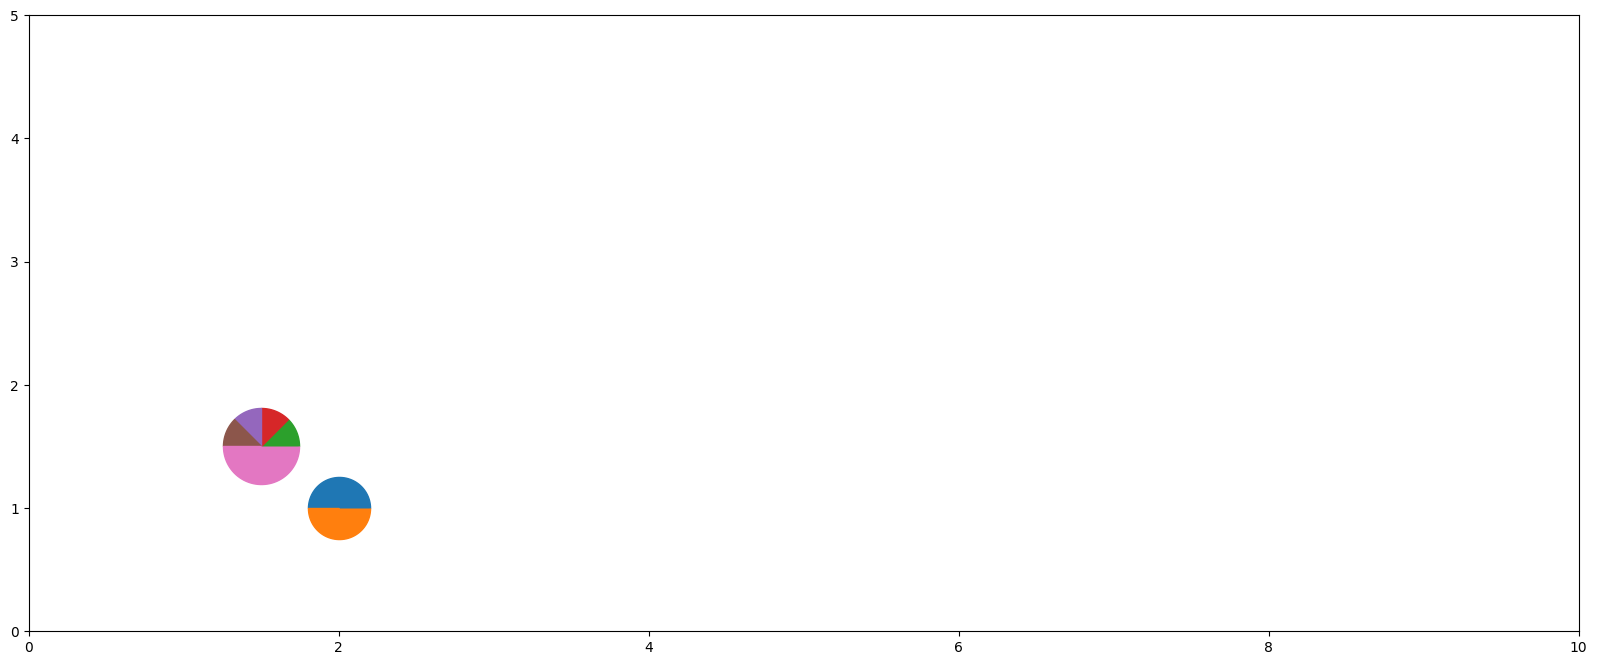

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20,8))
draw_pie([2,2], 2, 1, 2000, ax=ax)
draw_pie([1,1,1,1,4], 1.5,1.5, 3000, ax=ax)
plt.xlim(0,10)
plt.ylim(0, 5)
plt.show()

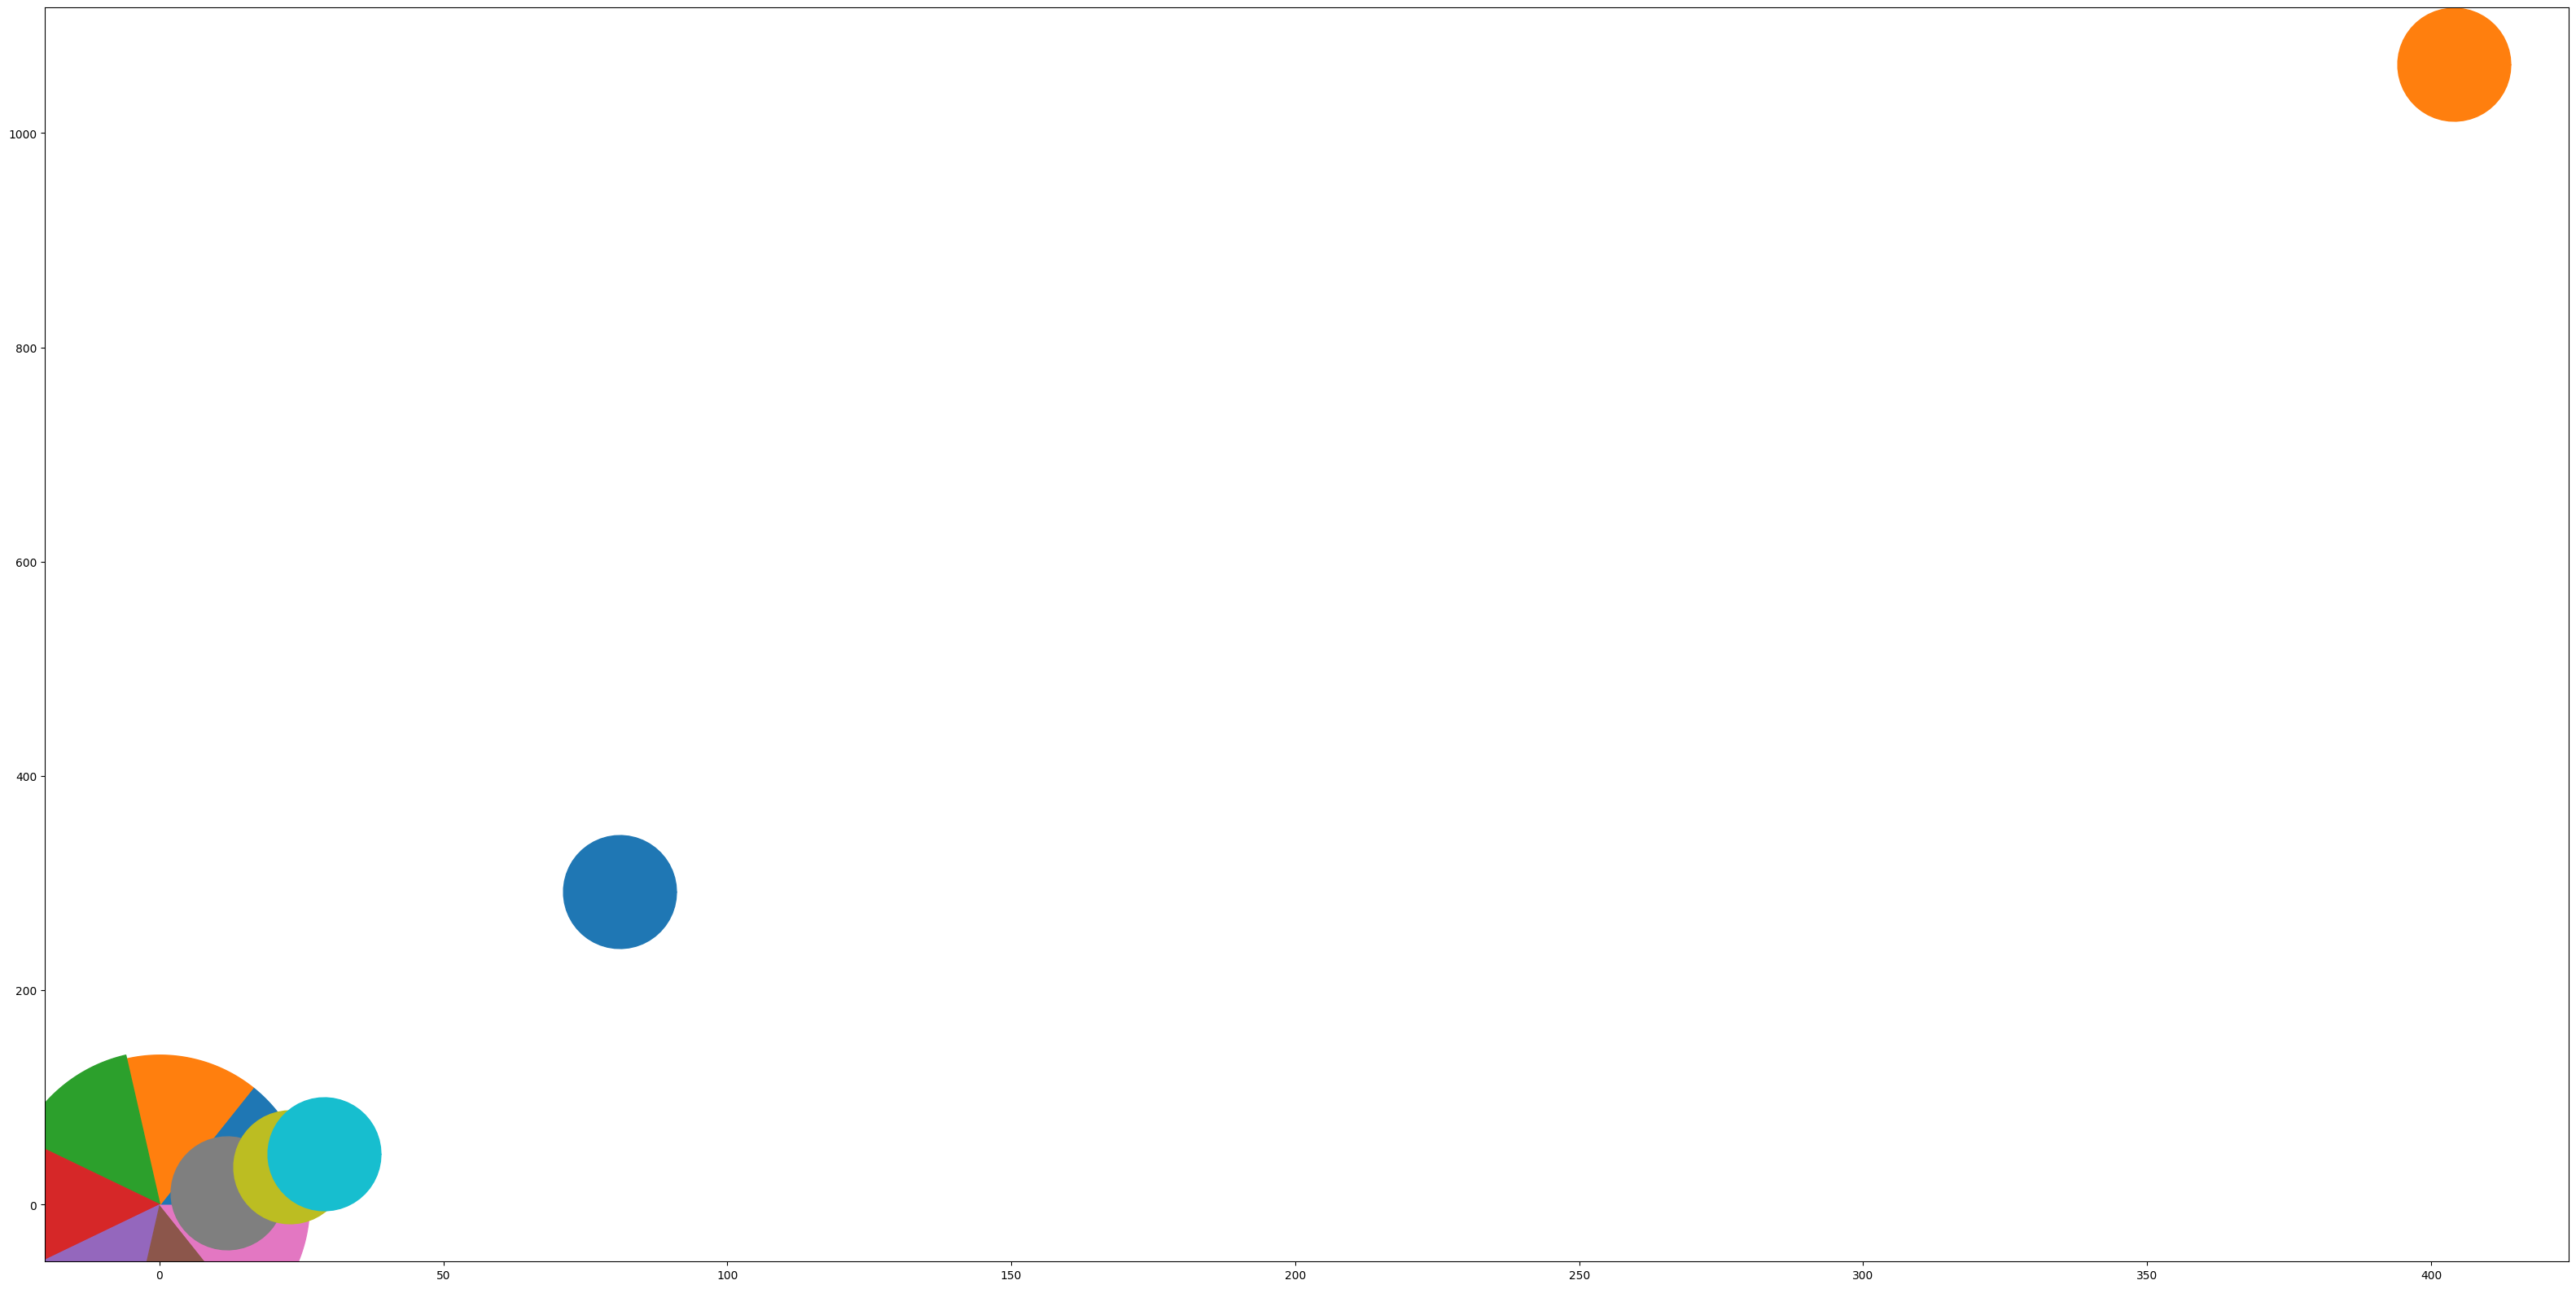

In [62]:
fig, ax = plt.subplots(figsize=(40,20))
for (x,y), d in not_supported_feature_impact_df.groupby(['Total Number Assertions','MOA Total Sum Impact Score']):
    dist = d['Category'].value_counts()
    draw_pie(dist, x, y, 10000*len(d), ax=ax)
plt.show()

In [63]:
not_supported_variant_impact_df = pd.read_csv("../not_supported_variant_impact_df.csv", sep=",")

In [64]:
merged_not_supported_impact_df = pd.merge(not_supported_feature_impact_df, not_supported_variant_impact_df, on='Category')
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants
0,Expression,11,12,11,3618.00,9.397403,7.681529,614,55.70%,291
1,Epigenetic Modification,0,0,0,285.50,0.741558,0.606157,24,91.67%,15
2,Fusion,0,0,0,5689.25,14.777273,12.079087,1239,58.43%,308
3,Protein Consequence,1064,404,169,2683.75,6.970779,5.697983,301,63.46%,128
4,Gene Function,0,0,0,1822.50,4.733766,3.869427,347,44.38%,90
5,Rearrangements,292,81,38,653.00,1.696104,1.386412,137,38.69%,52
6,Copy Number,47,29,17,207.00,0.537662,0.439490,64,42.19%,34
7,Other,35,23,9,673.50,1.749351,1.429936,162,37.04%,93
8,Genotypes Easy,0,0,0,195.00,0.506494,0.414013,23,56.52%,11
9,Genotypes Compound,0,0,0,117.50,0.305195,0.249469,7,57.14%,6


In [65]:
merged_not_supported_impact_df['Sum Variants'] = merged_not_supported_impact_df['Total Number Evidence Items']+merged_not_supported_impact_df['Total Number Assertions']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Variants
0,Expression,11,12,11,3618.00,9.397403,7.681529,614,55.70%,291,626
1,Epigenetic Modification,0,0,0,285.50,0.741558,0.606157,24,91.67%,15,24
2,Fusion,0,0,0,5689.25,14.777273,12.079087,1239,58.43%,308,1239
3,Protein Consequence,1064,404,169,2683.75,6.970779,5.697983,301,63.46%,128,705
4,Gene Function,0,0,0,1822.50,4.733766,3.869427,347,44.38%,90,347
5,Rearrangements,292,81,38,653.00,1.696104,1.386412,137,38.69%,52,218
6,Copy Number,47,29,17,207.00,0.537662,0.439490,64,42.19%,34,93
7,Other,35,23,9,673.50,1.749351,1.429936,162,37.04%,93,185
8,Genotypes Easy,0,0,0,195.00,0.506494,0.414013,23,56.52%,11,23
9,Genotypes Compound,0,0,0,117.50,0.305195,0.249469,7,57.14%,6,7


In [66]:
merged_not_supported_impact_df['Sum Impact Score'] = merged_not_supported_impact_df['CIVIC Total Sum Impact Score']+merged_not_supported_impact_df['MOA Total Sum Impact Score']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Variants,Sum Impact Score
0,Expression,11,12,11,3618.00,9.397403,7.681529,614,55.70%,291,626,3629.00
1,Epigenetic Modification,0,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,285.50
2,Fusion,0,0,0,5689.25,14.777273,12.079087,1239,58.43%,308,1239,5689.25
3,Protein Consequence,1064,404,169,2683.75,6.970779,5.697983,301,63.46%,128,705,3747.75
4,Gene Function,0,0,0,1822.50,4.733766,3.869427,347,44.38%,90,347,1822.50
5,Rearrangements,292,81,38,653.00,1.696104,1.386412,137,38.69%,52,218,945.00
6,Copy Number,47,29,17,207.00,0.537662,0.439490,64,42.19%,34,93,254.00
7,Other,35,23,9,673.50,1.749351,1.429936,162,37.04%,93,185,708.50
8,Genotypes Easy,0,0,0,195.00,0.506494,0.414013,23,56.52%,11,23,195.00
9,Genotypes Compound,0,0,0,117.50,0.305195,0.249469,7,57.14%,6,7,117.50


In [67]:
merged_not_supported_impact_df['Ratio of MOA Features to MOA+CIVIC per Category'] = merged_not_supported_impact_df['Total Number Features']/(merged_not_supported_impact_df['Total Number Features']+merged_not_supported_impact_df['Total Number Variants'])
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,11,12,11,3618.00,9.397403,7.681529,614,55.70%,291,626,3629.00,0.036424
1,Epigenetic Modification,0,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,285.50,0.000000
2,Fusion,0,0,0,5689.25,14.777273,12.079087,1239,58.43%,308,1239,5689.25,0.000000
3,Protein Consequence,1064,404,169,2683.75,6.970779,5.697983,301,63.46%,128,705,3747.75,0.569024
4,Gene Function,0,0,0,1822.50,4.733766,3.869427,347,44.38%,90,347,1822.50,0.000000
5,Rearrangements,292,81,38,653.00,1.696104,1.386412,137,38.69%,52,218,945.00,0.422222
6,Copy Number,47,29,17,207.00,0.537662,0.439490,64,42.19%,34,93,254.00,0.333333
7,Other,35,23,9,673.50,1.749351,1.429936,162,37.04%,93,185,708.50,0.088235
8,Genotypes Easy,0,0,0,195.00,0.506494,0.414013,23,56.52%,11,23,195.00,0.000000
9,Genotypes Compound,0,0,0,117.50,0.305195,0.249469,7,57.14%,6,7,117.50,0.000000


In [68]:
import numpy as np
from numpy import pi, sin, cos
import plotly.graph_objects as go

def degree2rad(degrees):
    return degrees*pi/180
def disk_part(center=[0,0], radius=1, start_angle=0, end_angle=90, n=50, seg=True):
    sta = degree2rad(start_angle)
    ea = degree2rad(end_angle)
    t = np.linspace(sta, ea, n)
    x = center[0] + radius*cos(t)
    y = center[1] +radius*sin(t)
    path = f"M {x[0]},{y[0]}"
    for xc, yc in zip(x[1:], y[1:]):
        path += f" L{xc},{yc}"
    if seg: #segment
        return path + " Z"
    else: #disk sector
        return path + f" L{center[0]},{center[1]} Z" #sector

In [69]:
layout = go.Layout(
    title="Title",
    xaxis=dict(
        title="Number of Evidence Items"
    ),
    yaxis=dict(
        title="Impact Score"
    ) ) 

In [70]:
fig = go.Figure(layout=layout)
for ix,row in merged_not_supported_impact_df.iterrows():
    proportion1 = 360*(row['Total Number Variants']/(row['Total Number Variants']+row['Total Number Features']))
    proportion2 = 360*(row['Total Number Features']/(row['Total Number Variants']+row['Total Number Features']))
    pie1 = disk_part(
        center=[row['Sum Variants'],row['Sum Impact Score']],
        radius = 100,
        start_angle = 90,
        end_angle = 90 + proportion1,
        seg=False
    )
    pie2 = disk_part(
        center=[row['Sum Variants'],row['Sum Impact Score']],
        radius = 100,
        start_angle = 90 + proportion1,
        end_angle = 360+90,
        seg=False
    )
    
    fig.add_shape(type='path',path=pie1, fillcolor='blue', opacity=.5)
    fig.add_shape(type='path',path=pie2, fillcolor='red', opacity=.5)
fig.update_layout(width=1000, height=1000, xaxis_range=[0,1300], yaxis_range=[0, 9000])


In [71]:
fig = go.Figure(layout=layout)
for ix,row in merged_not_supported_impact_df.iterrows():
    proportion1 = 360*(row['Total Number Variants']/(row['Total Number Variants']+row['Total Number Features']))
    proportion2 = 360*(row['Total Number Features']/(row['Total Number Variants']+row['Total Number Features']))
    pie1 = disk_part(
        center=[row['Sum Variants'],row['Sum Impact Score']],
        radius = (row['Total Number Variants']+row['Total Number Features'])/2,
        start_angle = 90,
        end_angle = 90 + proportion1,
        seg=False
    )
    pie2 = disk_part(
        center=[row['Sum Variants'],row['Sum Impact Score']],
        radius = (row['Total Number Variants']+row['Total Number Features'])/2,
        start_angle = 90 + proportion1,
        end_angle = 360+90,
        seg=False
    )
    
    fig.add_shape(type='path',path=pie1, fillcolor='blue', opacity=.5)
    fig.add_shape(type='path',path=pie2, fillcolor='red', opacity=.5)

    
# fig.add_annotation(hovertext= ['Category'])#, 'Total Number Assertions', 'CIVIC Total Sum Impact Score','MOA Total Sum Impact Score', 'Total Number Variants', 'Total Number Features'])

# fig.add_annotation(hovertext= ['Total Number Evidence Items', 'Total Number Assertions', 'CIVIC Total Sum Impact Score','MOA Total Sum Impact Score', 'Total Number Variants', 'Total Number Features'])
fig.update_yaxes(scaleanchor = "x", #IMPORTANT These yaxis settings ensure that the circle is non-deformed
                 scaleratio = 1)
fig.update_layout(width=1000, height=1000, xaxis_range=[0,3], yaxis_range=[0, 9000])


In [72]:
fig.write_html("merged_not_supported_impact_df_scatterpieplot.html")

In [74]:
merged_not_supported_impact_df.head()

,Category,MOA Total Sum Impact Score,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,11,12,11,3618.00,9.397403,7.681529,614,55.70%,291,626,3629.00,0.036424
1,Epigenetic Modification,0,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,285.50,0.000000
2,Fusion,0,0,0,5689.25,14.777273,12.079087,1239,58.43%,308,1239,5689.25,0.000000
3,Protein Consequence,1064,404,169,2683.75,6.970779,5.697983,301,63.46%,128,705,3747.75,0.569024
4,Gene Function,0,0,0,1822.50,4.733766,3.869427,347,44.38%,90,347,1822.50,0.000000


In [95]:
ratio_list = merged_not_supported_impact_df["Ratio of MOA Features to MOA+CIVIC per Category"].to_numpy()
ratio_list

array([0.03642384, 0.        , 0.        , 0.56902357, 0.        ,
       0.42222222, 0.33333333, 0.08823529, 0.        , 0.        ,
       0.        , 0.        ])

In [96]:
moa_civic_variant_sum_list = merged_not_supported_impact_df["Sum Variants"].to_numpy()
moa_civic_variant_sum_list

array([ 626,   24, 1239,  705,  347,  218,   93,  185,   23,    7,  924,
        471])

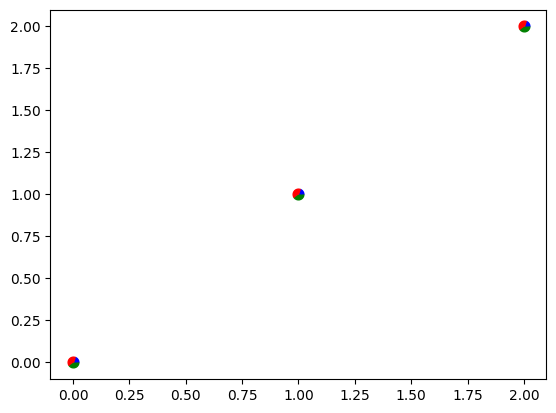

In [151]:
import numpy as np
import matplotlib.pyplot as plt

radi = np.array([.2, .6])

# define some sizes of the scatter marker
sizes = np.array([60])

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin

xys = []
ss = []
colors = ['blue', 'green', 'red']
for i in range(len(radi) + 1):
    
    if i == 0:
        r1 = radi[i]
        x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
        y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    elif i == len(radi) - 1:
        # last
        r1 = radi[i]
        x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi, 10)).tolist()
        y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi, 10)).tolist()
    else:
        # middle
        r1 = radi[i - 2]
        r2 = radi[i - 1]
        x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
        y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()

    xy = np.column_stack([x, y])
    xys.append(xy)
    ss.append(np.abs(xy).max())

fig, ax = plt.subplots()

for i in range(len(xys)):
    xy1 = xys[i]
    s1 = ss[i]
    color = colors[i]
    ax.scatter(range(len(xys)), range(len(xys)), marker=xy1,
            s=s1 ** 2 * sizes, facecolor=color)
    
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

radi = ratio_list

# define some sizes of the scatter marker
sizes = moa_civic_variant_sum_list

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin

xys = []
ss = []
colors = ['blue', 'green', 'red', ]
for i in range(len(radi) + 1):
    
    if i == 0:
        r1 = radi[i]
        x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
        y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
    elif i == len(radi) - 1:
        # last
        r1 = radi[i]
        x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi, 10)).tolist()
        y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi, 10)).tolist()
    else:
        # middle
        r1 = radi[i - 2]
        r2 = radi[i - 1]
        x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
        y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()

    xy = np.column_stack([x, y])
    xys.append(xy)
    ss.append(np.abs(xy).max())

fig, ax = plt.subplots()
for i in range(len(xys)):
    xy1 = xys[i]
    s1 = ss[i]
    color = colors[i]
    ax.scatter(range(1), range(3), marker=xy1,
            s=s1 ** 2 * sizes, facecolor=color)

plt.show()

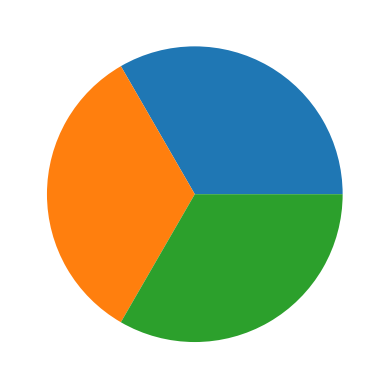

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# first define the ratios
r1 = 0.2       # 20%
r2 = r1 + 0.4  # 40%

# define some sizes of the scatter marker
sizes = np.array([60, 80, 120])

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin
x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
xy1 = np.column_stack([x, y])
s1 = np.abs(xy1).max()

x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
xy2 = np.column_stack([x, y])
s2 = np.abs(xy2).max()

x = [0] + np.cos(np.linspace(2 * np.pi * r2, 2 * np.pi, 10)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r2, 2 * np.pi, 10)).tolist()
xy3 = np.column_stack([x, y])
s3 = np.abs(xy3).max()

fig, ax = plt.subplots()
ax.pie([s1, s3, s3])
# ax.scatter(range(3), range(3), marker=xy1,
#            s=s1 ** 2 * sizes, facecolor='blue')
# ax.scatter(range(3), range(3), marker=xy2,
#            s=s2 ** 2 * sizes, facecolor='green')
# ax.scatter(range(3), range(3), marker=xy3,
#            s=s3 ** 2 * sizes, facecolor='red')

plt.show()